In [1]:
# Run this cell to import pyspark and to define start_spark() and stop_spark()

import findspark

findspark.init()

import getpass
import pandas as pd
import pyspark
import random
import re

from IPython.display import display, HTML
from pyspark import SparkContext
from pyspark.sql import SparkSession


# Functions used below

def username():
    """Get username with any domain information removed.
    """

    return re.sub('@.*', '', getpass.getuser())


def dict_to_html(d):
    """Convert a Python dictionary into a two column table for display.
    """

    html = []

    html.append(f'<table width="100%" style="width:100%; font-family: monospace;">')
    for k, v in d.items():
        html.append(f'<tr><td style="text-align:left;">{k}</td><td>{v}</td></tr>')
    html.append(f'</table>')

    return ''.join(html)


def show_as_html(df, n=20):
    """Leverage existing pandas jupyter integration to show a spark dataframe as html.
    
    Args:
        n (int): number of rows to show (default: 20)
    """

    display(df.limit(n).toPandas())

    
def display_spark():
    """Display the status of the active Spark session if one is currently running.
    """
    
    if 'spark' in globals() and 'sc' in globals():

        name = sc.getConf().get("spark.app.name")
        
        html = [
            f'<p><b>Spark</b></p>',
            f'<p>The spark session is <b><span style="color:green">active</span></b>, look for <code>{name}</code> under the running applications section in the Spark UI.</p>',
            f'<ul>',
            f'<li><a href="http://mathmadslinux2p.canterbury.ac.nz:8080/" target="_blank">Spark UI</a></li>',
            f'<li><a href="{sc.uiWebUrl}" target="_blank">Spark Application UI</a></li>',
            f'</ul>',
            f'<p><b>Config</b></p>',
            dict_to_html(dict(sc.getConf().getAll())),
            f'<p><b>Notes</b></p>',
            f'<ul>',
            f'<li>The spark session <code>spark</code> and spark context <code>sc</code> global variables have been defined by <code>start_spark()</code>.</li>',
            f'<li>Please run <code>stop_spark()</code> before closing the notebook or restarting the kernel or kill <code>{name}</code> by hand using the link in the Spark UI.</li>',
            f'</ul>',
        ]
        display(HTML(''.join(html)))
        
    else:
        
        html = [
            f'<p><b>Spark</b></p>',
            f'<p>The spark session is <b><span style="color:red">stopped</span></b>, confirm that <code>{username() + " (jupyter)"}</code> is under the completed applications section in the Spark UI.</p>',
            f'<ul>',
            f'<li><a href="http://mathmadslinux2p.canterbury.ac.nz:8080/" target="_blank">Spark UI</a></li>',
            f'</ul>',
        ]
        display(HTML(''.join(html)))


# Functions to start and stop spark

def start_spark(executor_instances=2, executor_cores=1, worker_memory=1, master_memory=1):
    """Start a new Spark session and define globals for SparkSession (spark) and SparkContext (sc).
    
    Args:
        executor_instances (int): number of executors (default: 2)
        executor_cores (int): number of cores per executor (default: 1)
        worker_memory (float): worker memory (default: 1)
        master_memory (float): master memory (default: 1)
    """

    global spark
    global sc

    user = username()
    
    cores = executor_instances * executor_cores
    partitions = cores * 4
    port = 4000 + random.randint(1, 999)

    spark = (
        SparkSession.builder
        .master("spark://masternode2:7077")
        .config("spark.driver.extraJavaOptions", f"-Dderby.system.home=/tmp/{user}/spark/")
        .config("spark.dynamicAllocation.enabled", "false")
        .config("spark.executor.instances", str(executor_instances))
        .config("spark.executor.cores", str(executor_cores))
        .config("spark.cores.max", str(cores))
        .config("spark.executor.memory", f"{worker_memory}g")
        .config("spark.driver.memory", f"{master_memory}g")
        .config("spark.driver.maxResultSize", "0")
        .config("spark.sql.shuffle.partitions", str(partitions))
        .config("spark.ui.port", str(port))
        .appName(user + " (jupyter)")
        .getOrCreate()
    )
    sc = SparkContext.getOrCreate()
    
    display_spark()

    
def stop_spark():
    """Stop the active Spark session and delete globals for SparkSession (spark) and SparkContext (sc).
    """

    global spark
    global sc

    if 'spark' in globals() and 'sc' in globals():

        spark.stop()

        del spark
        del sc

    display_spark()


# Make css changes to improve spark output readability

html = [
    '<style>',
    'pre { white-space: pre !important; }',
    'table.dataframe td { white-space: nowrap !important; }',
    'table.dataframe thead th:first-child, table.dataframe tbody th { display: none; }',
    '</style>',
]
display(HTML(''.join(html)))

In [2]:
from matplotlib import pyplot as plt
import numpy as np
import os
import math
from pyspark.sql import Row, DataFrame, Window, functions as F
from pyspark.sql.types import *

In [27]:
start_spark(executor_instances=8, executor_cores=2, worker_memory=4, master_memory=4)

spark.sql.shuffle.partitions,64
spark.dynamicAllocation.enabled,false
spark.app.id,app-20240913141038-0724
spark.sql.warehouse.dir,file:/users/home/ywa286/Assignment1/notebook/spark-warehouse
spark.driver.memory,4g
spark.executor.memory,4g
spark.app.startTime,1726193438040
spark.master,spark://masternode2:7077
spark.cores.max,16
spark.executor.id,driver
spark.executor.instances,8


## Q1, Visulization of New Zealand Temperature

### (a)

In [4]:
# Define schma for Daily
daily_schema = StructType([
    StructField("ID", StringType(), nullable=False),
    StructField("DATE", StringType(), nullable=False),
    StructField("ELEMENT", StringType(), nullable=False),
    StructField("VALUE", FloatType(), nullable=False),
    StructField("MEASUREMENT_FLAG", StringType(), nullable=True),
    StructField("QUALITY_FLAG", StringType(), nullable=True),
    StructField("SOURCE_FLAG", StringType(), nullable=True),
    StructField("OBSERVATION_TIME", StringType(), nullable=True)
])
# Set the path to the daily data
daily_path = "/data/ghcnd/daily/*.csv.gz"

# Read the daily data
daily_df = spark.read.format("csv") \
    .option("header", "false") \
    .option("sep", ",") \
    .schema(daily_schema) \
    .load(daily_path)

In [5]:
# get the observation which come from nz
nz_stations_df = spark.read.parquet("station_enriched.parquet").filter(F.col("COUNTRY_CODE") == "NZ")
nz_daily_df = daily_df.join(nz_stations_df, on="ID", how="inner")

In [6]:
# extract the observation which elements equal to tmin and tmax. just remain the useful column
nz_tmin_tmax_df = nz_daily_df.filter((nz_daily_df.ELEMENT == "TMIN") | (nz_daily_df.ELEMENT == "TMAX"))
nz_tmin_tmax_df = nz_tmin_tmax_df.select("ID", "DATE", "ELEMENT", "VALUE")

In [7]:
# save the result
output_directory = "./nz_tmin_tmax.csv"
nz_tmin_tmax_df.write.mode("overwrite").csv(output_directory, header=True)

In [28]:
# load data and transfer the DATE column to date type
nz_temp_df = spark.read.csv("nz_tmin_tmax.csv", header=True)
nz_temp_df = nz_temp_df.withColumn("DATE", F.to_date(nz_temp_df["DATE"], "yyyyMMdd"))

In [29]:
num_observation = nz_temp_df.count()
print(f"There are {num_observation} observations in nz")

# Calculate year span
result = nz_temp_df.agg(
    F.year(F.max("DATE")).alias("max_year"),
    F.year(F.min("DATE")).alias("min_year")
).collect()[0]

min_year = result["min_year"]
max_year = result["max_year"]

year_span = result["max_year"] - result["min_year"] + 1

print(f"The year span from {min_year} to {max_year},  {year_span} years in total")

There are 487760 observations in nz
The year span from 1940 to 2024,  85 years in total


### (b)

In [30]:
# separate two element to two tables and fix the numeric unit
nz_temp_df = nz_temp_df.toPandas()
tmax = nz_temp_df[nz_temp_df.ELEMENT == "TMAX"][['DATE', 'VALUE']]
tmin = nz_temp_df[nz_temp_df.ELEMENT == "TMIN"][['DATE', 'VALUE']]
tmax['VALUE'] = pd.to_numeric(tmax['VALUE'], errors='coerce').div(10)
tmin['VALUE'] = pd.to_numeric(tmin['VALUE'], errors='coerce').div(10)

In [31]:
# Processing maximum temperature data
# Convert DATE column to datetime type
tmax['DATE'] = pd.to_datetime(tmax['DATE'])

# Group by date, calculate mean VALUE, and reset index
tmax_mean = tmax.groupby('DATE')['VALUE'].mean().reset_index()

# Sort by date
tmax_mean = tmax_mean.sort_values('DATE')

# Print the first 5 rows
print(tmax_mean.head())

# Processing minimum temperature data
# Convert DATE column to datetime type
tmin['DATE'] = pd.to_datetime(tmin['DATE'])

# Group by date, calculate mean VALUE, and reset index
tmin_mean = tmin.groupby('DATE')['VALUE'].mean().reset_index()

# Sort by date
tmin_mean = tmin_mean.sort_values('DATE')

# Print the first 5 rows
print(tmin_mean.head())

        DATE  VALUE
0 1940-03-08   26.1
1 1940-03-09   24.3
2 1940-03-10   25.0
3 1940-03-11   26.1
4 1940-03-12   23.3
        DATE  VALUE
0 1940-03-08   21.1
1 1940-03-09   22.7
2 1940-03-10   22.2
3 1940-03-11   19.7
4 1940-03-12   18.3


In [32]:
# get all unique station id in NZ
station_list = nz_temp_df["ID"].unique()
print(station_list)

['NZ000093012' 'NZ000093292' 'NZ000093417' 'NZ000093844' 'NZ000093994'
 'NZ000933090' 'NZ000936150' 'NZ000937470' 'NZ000939450' 'NZ000939870'
 'NZM00093110' 'NZM00093439' 'NZM00093678' 'NZM00093781' 'NZM00093929']


In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from statsmodels.tsa.seasonal import seasonal_decompose

%matplotlib inline
plt.style.use('seaborn')

In [21]:
def plot_temperature_moving_average(station_id, window_size, output_path):
    """
    Plot the moving average of maximum and minimum temperatures for a given station.
    Args:
        station_id (str): The ID of the weather station.
        window_size (int): The size of the moving average window.
        output_path (str): The directory path to save the output plot.
    Returns:
        None
    """
    # Filter data for the specified station and sort by date
    station_data = nz_temp_df[nz_temp_df['ID'] == station_id].sort_values(by='DATE', ascending=True)
    
    # Convert temperature values to numeric and scale to Celsius
    station_data['VALUE'] = pd.to_numeric(station_data['VALUE'], errors='coerce') / 10
    
    # Separate maximum and minimum temperature data
    tmax = station_data[station_data.ELEMENT == "TMAX"][['DATE', 'VALUE']]
    tmin = station_data[station_data.ELEMENT == "TMIN"][['DATE', 'VALUE']]
    
    # Convert DATE to datetime and set as index
    for df in [tmax, tmin]:
        df['DATE'] = pd.to_datetime(df['DATE'])
        df.set_index('DATE', inplace=True)
    
    # Calculate moving averages
    tmax_ma = tmax.rolling(window=window_size).mean()
    tmin_ma = tmin.rolling(window=window_size).mean()
    
    # Create figure
    plt.figure(figsize=(12, 6))
    tmin_color = '#3a7ca5'  # Deep blue-green
    tmax_color = '#f9a03f'  # Light orange
    
    # Plot moving averages using scatter
    plt.scatter(tmax_ma.index, tmax_ma['VALUE'], color=tmax_color, s=1, alpha=0.7, label='_nolegend_')
    plt.scatter(tmin_ma.index, tmin_ma['VALUE'], color=tmin_color, s=1, alpha=0.7, label='_nolegend_')
    
    # Create larger points for the legend
    plt.scatter([], [], color=tmax_color, s=50, label='Max Temperature (Moving Avg)')
    plt.scatter([], [], color=tmin_color, s=50, label='Min Temperature (Moving Avg)')
    
    # Set plot title and labels
    plt.title(f'Station {station_id} Max and Min Temperature Record (Moving Avg with Window Size {window_size})')
    plt.xlabel('Date')
    plt.ylabel('Temperature (°C)')
    plt.legend()
    
    # Add grid
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Set x and y axis limits
    plt.xlim(pd.Timestamp('1940-01-01'), pd.Timestamp('2025-01-01'))
    plt.ylim(-5, 30)
    
    # Format x-axis date labels
    plt.gcf().autofmt_xdate()
    plt.tight_layout()
    
    # Save the plot
    plt.savefig(os.path.join(output_path, f'{station_id}.png'), dpi=300, bbox_inches='tight')
    plt.show()
    
    # Close the plot to free up memory
    plt.close()

In [ ]:
for station in station_list:
    plot_temperature_moving_average(station, 90, '../supplementary/nz_tmin_tmax_visualization/')

In [33]:
def decompose_and_plot_dual(tmax_mean, tmin_mean, title, period=365):
    """
    Perform time series decomposition on maximum and minimum temperature data and plot the results.

    Args:
        tmax_mean (pd.DataFrame): DataFrame containing maximum temperature data.
        tmin_mean (pd.DataFrame): DataFrame containing minimum temperature data.
        title (str): Title for the plot.
        period (int, optional): The period of the seasonal component. Defaults to 365 (annual cycle).

    Returns:
        None
    """
    # Convert DATE columns to datetime
    tmax_mean['DATE'] = pd.to_datetime(tmax_mean['DATE'])
    tmin_mean['DATE'] = pd.to_datetime(tmin_mean['DATE'])
    
    # Set DATE as index without modifying original DataFrames
    tmax_mean_index = tmax_mean.set_index('DATE', inplace=False)
    tmin_mean_index = tmin_mean.set_index('DATE', inplace=False)
    
    # Perform seasonal decomposition
    try:
        tmax_result = seasonal_decompose(tmax_mean_index, model='additive', freq=period)
        tmin_result = seasonal_decompose(tmin_mean_index, model='additive', freq=period)
    except Exception as e:
        print(f"Error during seasonal decomposition: {str(e)}")
        print("Please ensure your data is appropriate for seasonal decomposition.")
        return
    
    # Create subplots in a 2x2 grid
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 16))
    plt.subplots_adjust(top=1.5)  # Increase top margin
    
    # Add main title
    fig.suptitle(title, fontsize=16, y=0.97)  # Adjust y to move title up
    
    # Define color palette
    tmin_color = '#3a7ca5'  # Deep blue-green for max temperature
    tmax_color = '#f9a03f'  # Light orange for min temperature
    
    # Plot Observed data
    ax1.plot(tmax_mean_index.index, tmax_mean_index.values, label='TMAX', color=tmax_color, linewidth=0.8, alpha=0.8)
    ax1.plot(tmin_mean_index.index, tmin_mean_index.values, label='TMIN', color=tmin_color, linewidth=0.8, alpha=0.8)
    ax1.set_ylabel('Temperature (°C)')
    ax1.legend()
    ax1.set_title('Observed')
    
    # Plot Trend component
    ax2.plot(tmax_mean_index.index, tmax_result.trend, label='TMAX', color=tmax_color, linewidth=0.8, alpha=0.8)
    ax2.plot(tmin_mean_index.index, tmin_result.trend, label='TMIN', color=tmin_color, linewidth=0.8, alpha=0.8)
    ax2.set_ylabel('Temperature (°C)')
    ax2.legend()
    ax2.set_title('Trend')
    
    # Plot Seasonal component
    ax3.plot(tmax_mean_index.index, tmax_result.seasonal, label='TMAX', color=tmax_color, linewidth=0.8, alpha=0.8)
    ax3.plot(tmin_mean_index.index, tmin_result.seasonal, label='TMIN', color=tmin_color, linewidth=0.8, alpha=0.8)
    ax3.set_ylabel('Temperature Deviation (°C)')
    ax3.legend()
    ax3.set_title('Seasonal')
    
    # Plot Residual component
    ax4.plot(tmax_mean_index.index, tmax_result.resid, label='TMAX', color=tmax_color, linewidth=0.8, alpha=0.8)
    ax4.plot(tmin_mean_index.index, tmin_result.resid, label='TMIN', color=tmin_color, linewidth=0.8, alpha=0.8)
    ax4.set_ylabel('Temperature Deviation (°C)')
    ax4.legend()
    ax4.set_title('Residual')
    
    # Set fixed axis ranges for all subplots
    for ax in [ax1, ax2]:
        ax.set_ylim(-5, 30)
        ax.set_xlim(pd.Timestamp('1940-01-01'), pd.Timestamp('2025-01-01'))
    
    ax3.set_ylim(-10, 10)
    ax3.set_xlim(pd.Timestamp('1940-01-01'), pd.Timestamp('2025-01-01'))
    
    ax4.set_ylim(-20, 20)
    ax4.set_xlim(pd.Timestamp('1940-01-01'), pd.Timestamp('2025-01-01'))
    
    # Adjust layout and save figure
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig('../supplementary/nz_tmin_tmax_visualization/NZ_AVG_Temp_visualize.png', dpi=300, bbox_inches='tight', pad_inches=0.5)
    
    plt.show()
    plt.close()

In [ ]:
decompose_and_plot_dual(tmax_mean, tmin_mean, "Seasonal Decomposition of Average Max and Min Temperatures in NZ")

## Q2, Globally Average Precipitations

### (a)

In [190]:
# Filter the daily dataframe to include only precipitation (PRCP) data
prcp_daily_df = daily_df.filter(F.col("ELEMENT") == "PRCP")

# Extract the country code from the ID column (assuming first two characters represent the country code)
prcp_daily_df = prcp_daily_df.withColumn("COUNTRY_CODE", F.substring("ID", 1, 2))

# Select only the relevant columns for our analysis
prcp_daily_df = prcp_daily_df.select("DATE", "VALUE", "COUNTRY_CODE")

# Extract the year from the DATE column
prcp_daily_df = prcp_daily_df.withColumn("YEAR", F.year(F.to_date("DATE", "yyyyMMdd")))

# Group the data by year and country code, then calculate the average rainfall
result_df = prcp_daily_df.groupBy("YEAR", "COUNTRY_CODE") \
    .agg(F.avg("VALUE").alias("AVG_RAINFALL"))

# Sort the results by year in ascending order
result_df = result_df.orderBy(F.asc("YEAR"))

# Display the results as an HTML table
show_as_html(result_df)
result_df.write.mode("overwrite").csv('./global_avg_prcp.csv', header=True)

,YEAR,COUNTRY_CODE,AVG_RAINFALL
0,1750,AS,22.204388
1,1781,GM,24.558904
2,1782,GM,13.712329
3,1783,GM,17.832877
4,1784,GM,16.576503
5,1785,GM,16.169863
6,1786,GM,24.167123
7,1789,GM,18.476712
8,1790,GM,15.501370
9,1791,GM,17.475645


In [193]:
global_prcp_avg = spark.read.csv("./global_avg_prcp.csv", header=True)

In [194]:
# Calculate summary statistics from the global precipitation average dataframe
stats = global_prcp_avg.agg(
    F.countDistinct("COUNTRY_CODE").alias("unique_country_codes"),
    F.count("*").alias("total_rows"),
    F.countDistinct("YEAR").alias("unique_years")
).collect()[0]

# Print the summary statistics with improved, more informative output strings
print(f"Number of unique countries: {stats['unique_country_codes']}")
print(f"Total number of records: {stats['total_rows']}")
print(f"Number of years in the dataset: {stats['unique_years']}")

Number of unique countries: 218
Total number of records: 17548
Number of years in the dataset: 241


In [195]:
global_prcp_avg_df = global_prcp_avg.orderBy(F.asc("YEAR")).toPandas()

Descriptive statistics for average rainfall by year and country:
                         count        mean  std         min         25%  \
YEAR       COUNTRY_CODE                                                   
1750-01-01 AS              1.0   22.204388  NaN   22.204388   22.204388   
1781-01-01 GM              1.0   24.558904  NaN   24.558904   24.558904   
1782-01-01 GM              1.0   13.712329  NaN   13.712329   13.712329   
1783-01-01 GM              1.0   17.832877  NaN   17.832877   17.832877   
1784-01-01 GM              1.0   16.576503  NaN   16.576503   16.576503   
1785-01-01 GM              1.0   16.169863  NaN   16.169863   16.169863   
1786-01-01 GM              1.0   24.167123  NaN   24.167123   24.167123   
1789-01-01 GM              1.0   18.476712  NaN   18.476712   18.476712   
1790-01-01 GM              1.0   15.501370  NaN   15.501370   15.501370   
1791-01-01 GM              1.0   17.475645  NaN   17.475645   17.475645   
1792-01-01 GM              1.0   18

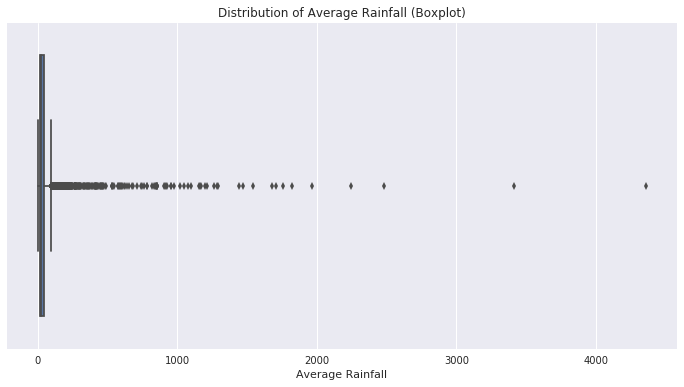

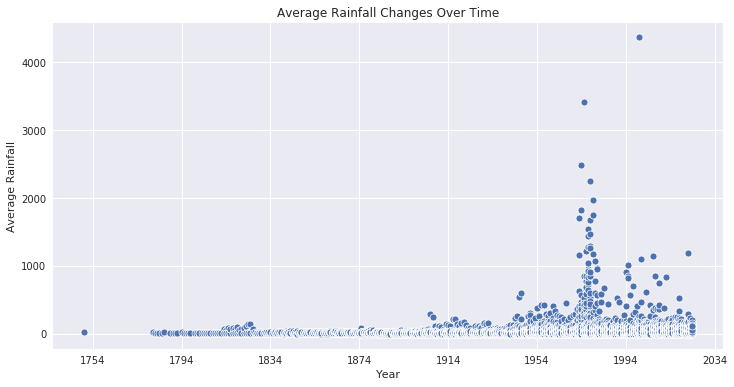

In [197]:
# Convert YEAR to datetime and AVG_RAINFALL to float
global_prcp_avg_df['YEAR'] = pd.to_datetime(global_prcp_avg_df['YEAR'], format='%Y')
global_prcp_avg_df['AVG_RAINFALL'] = global_prcp_avg_df['AVG_RAINFALL'].astype(float)

# Calculate descriptive statistics grouped by year and country
stats_by_year_country = global_prcp_avg_df.groupby(['YEAR', 'COUNTRY_CODE'])['AVG_RAINFALL'].describe()

# Display grouped statistics
print("Descriptive statistics for average rainfall by year and country:")
print(stats_by_year_country)

# Calculate and display overall descriptive statistics
overall_stats = global_prcp_avg_df['AVG_RAINFALL'].describe()
print("\nOverall average rainfall descriptive statistics:")
print(overall_stats)

# Identify outliers using the Interquartile Range (IQR) method
Q1 = global_prcp_avg_df['AVG_RAINFALL'].quantile(0.25)
Q3 = global_prcp_avg_df['AVG_RAINFALL'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers = global_prcp_avg_df[(global_prcp_avg_df['AVG_RAINFALL'] < lower_bound) | (global_prcp_avg_df['AVG_RAINFALL'] > upper_bound)]

print("\nOutliers in average rainfall data:")
print(outliers)

# Visualize the distribution of average rainfall using a boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(x=global_prcp_avg_df['AVG_RAINFALL'])
plt.title('Distribution of Average Rainfall (Boxplot)')
plt.xlabel('Average Rainfall')
plt.show()

# Plot average rainfall changes over time using a scatter plot
plt.figure(figsize=(12, 6))
sns.scatterplot(data=global_prcp_avg_df, x='YEAR', y='AVG_RAINFALL')
plt.title('Average Rainfall Changes Over Time')
plt.xlabel('Year')
plt.ylabel('Average Rainfall')
plt.show()

In [198]:
# 检查是否有异常大的值
high_values = global_prcp_avg_df[pd.to_numeric(global_prcp_avg_df['AVG_RAINFALL']) > 200]
print("\n greater than 200：")
print(high_values)


 greater than 200：
            YEAR COUNTRY_CODE  AVG_RAINFALL
1671  1906-01-01           NG    285.700000
1754  1907-01-01           NG    245.428571
2216  1916-01-01           NG    213.111111
2289  1917-01-01           NG    226.000000
4064  1944-01-01           DR    229.333333
4189  1945-01-01           DR    265.600000
4257  1946-01-01           DR    547.000000
4377  1947-01-01           PP    221.600000
4393  1947-01-01           DR    600.500000
4634  1950-01-01           DR    262.333333
4779  1951-01-01           NC    307.095890
4808  1951-01-01           IR    279.500000
5006  1953-01-01           CI    234.000000
5204  1954-01-01           NC    388.164384
5402  1955-01-01           NC    270.136986
5524  1956-01-01           NC    418.060109
5580  1957-01-01           CE    430.256410
5701  1958-01-01           NC    295.068493
5881  1959-01-01           NC    268.547945
6009  1960-01-01           NC    303.032787
6220  1961-01-01           NC    412.602740
6226  1961-0

In [201]:
# Find the row with the maximum average rainfall
max_rainfall_row = global_prcp_avg_df.loc[pd.to_numeric(global_prcp_avg_df['AVG_RAINFALL']).idxmax()]

# Print the results with improved, more informative output
print("Row with the maximum average rainfall:")
print(max_rainfall_row.to_string())

# Optional: Print a more detailed breakdown of the information
print("\nDetailed information:")
print(f"Year: {max_rainfall_row['YEAR']}")
print(f"Country Code: {max_rainfall_row['COUNTRY_CODE']}")
print(f"Average Rainfall: {max_rainfall_row['AVG_RAINFALL']} (tenth mm)")

Row with the maximum average rainfall:
YEAR            2000-01-01 00:00:00
COUNTRY_CODE                     EK
AVG_RAINFALL                   4361

Detailed information:
Year: 2000-01-01 00:00:00
Country Code: EK
Average Rainfall: 4361.0 (tenth mm)


### (b)

In [205]:
import plotly.graph_objects as go

import json
import requests
from io import StringIO

In [ ]:
# Ensure 'COUNTRY_CODE' is string type
global_prcp_avg_2023_df['COUNTRY_CODE'] = global_prcp_avg_2023_df['COUNTRY_CODE'].astype(str)
# Ensure 'AVG_RAINFALL' is numeric type
global_prcp_avg_2023_df['AVG_RAINFALL'] = pd.to_numeric(global_prcp_avg_2023_df['AVG_RAINFALL'], errors='coerce')

# Download and load GeoJSON file containing ISO_A2 codes
url = "https://raw.githubusercontent.com/datasets/geo-countries/master/data/countries.geojson"
geojson = requests.get(url)

# Download the csv file containing FIPS codes
url = "https://raw.githubusercontent.com/dieghernan/Country-Codes-and-International-Organizations/master/outputs/Countrycodes.csv"
response = requests.get(url)
fips_csv = StringIO(response.text)
fips_df = pd.read_csv(fips_csv, header=0)

countries_geojson = json.loads(geojson.text)

# Modify GeoJSON file to use FIPS 10-4 codes
for feature in countries_geojson['features']:
    ISO_A2 = feature['properties'].get('ISO_A2')
    try:
        fips_code = fips_df.loc[fips_df['ISO_3166_2'] == ISO_A2, 'FIPS_GEC'].iloc[0]
    except IndexError:
        continue
    
    if fips_code:
        feature['id'] = fips_code

countries_geojson['features'][0]

# Create choropleth map
fig = go.Figure(go.Choropleth(
    geojson=countries_geojson,
    locations=global_prcp_avg_2023_df['COUNTRY_CODE'],
    z=global_prcp_avg_2023_df['AVG_RAINFALL'] / 10,
    colorscale='Blues',
    autocolorscale=False,
    reversescale=False,
    marker_line_color='darkgray',
    marker_line_width=0.5,
    colorbar_title='Average Rainfall (mm)',
    featureidkey='id'  # Use the 'id' field from the modified GeoJSON
))

# Update layout
fig.update_layout(
    title_text='Global Annual Average Rainfall (2023)',
    geo=dict(
        showframe=False,
        showcoastlines=True,
        projection_type='equirectangular'
    ),
    height=600,
    width=1000
)

fig.write_image("../supplementary/global_rainfall_2023.png")

In [35]:
stop_spark()